In [1]:
#packages import
import os
os.chdir('..') #cd to PiperNET folder

from pathlib import Path
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

#matplotlib settings
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
### Data import ###
from src.import_utils import get_config
from src.import_utils import import_sonicpd

config_path = Path('config/rnaseq_dataprep.yaml')
proteomes_all = pd.read_csv('data/rna-seq/proteomes_all.csv', index_col='id') #merged proteome file
sonicpd = import_sonicpd(get_config(config_path, data='orthogroups', file='sonicparanoid'))
blastDBs = get_config(Path('config/rnaseq_dataprep.yaml'), data='blastDB') #BLAST databases paths
seq_paths = get_config(config_path, data='enzymeDB') #sequences paths
prefixes = get_config(config_path, data='prefix', filepaths=False)
species_names = get_config(config_path, data='species', filepaths=False)
legend = get_config(config_path, data='colors', filepaths=False) #colors legend

In [3]:
#TODO: INCLUDE HERE THE BLAST SEARCH. BLAST SEARCH SHOULD BE THEN FILTERED FOR PRESENCE OF PFAM DOMAINS

### Count Piper-PKS candidates based on Pfam domains
The count of PKS candidates (i.e., Piper-PKS) in each species is displayed. Sequences are considered candidates if they contain either of the characteristic Pfam domains `PF00195` or `PF02797`

Total N° of candidates: 158


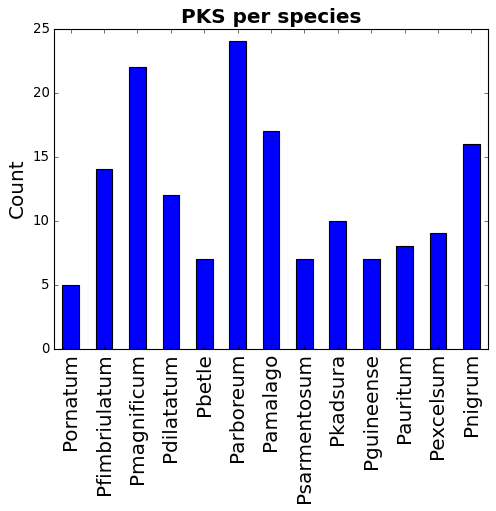

In [3]:
#keep sequences with PF00195 or PF02797
pks = proteomes_all[proteomes_all['pfam'].str.contains('PF00195|PF02797', na=False)] #keep 'PF00195' or 'PF02797
pks_count = pks.groupby('sample').size().rename(index=species_names) #count pks per sample, use species_names
print(f'Total N° of candidates: {pks_count.sum()}')

from src.rnaseq_utils import plot_count_per_species
plot_count_per_species(pks_count, title = 'PKS per species')

### ORF type and seqeunce lenght distribution of Piper-PKS
The ORF type (from TransDecoder) and sequence length distribution of Piper-PKS are displayed.

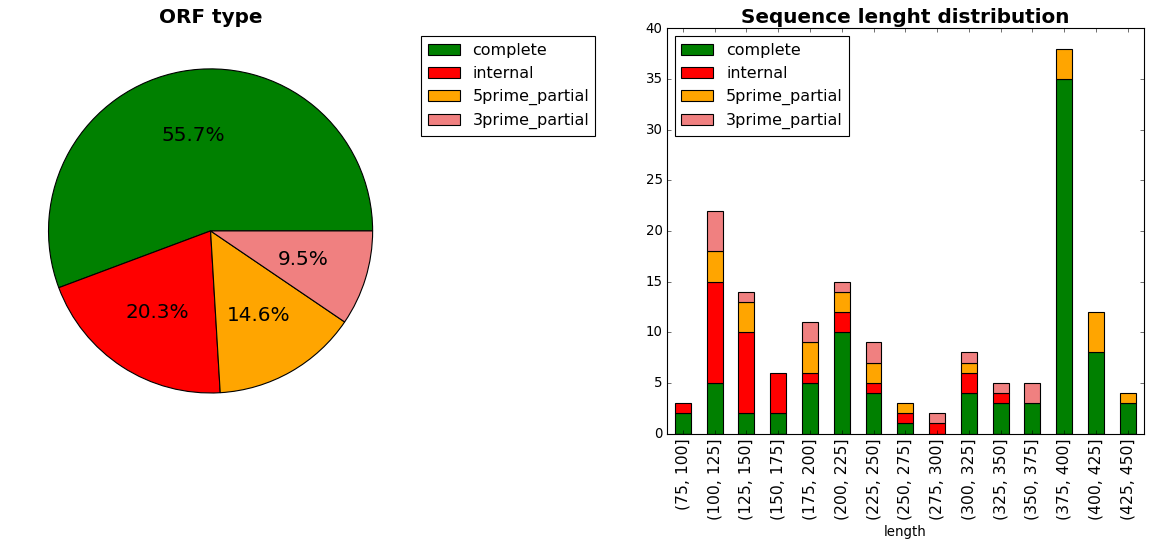

In [4]:
from src.rnaseq_utils import plot_orftype_and_lenght_distribution
plot_orftype_and_lenght_distribution(pks)

### Orthogroups of Piper-PKS
Orthogroups in `sonicpd` containting any Piper-PKS (`pks.index`) are retrieved.

TODO: assign annotation to orthogruops based on blast hits

In [6]:
#keep PKS-related orthogroups
sample_cols = [col for col in sonicpd.columns if 'piper' in col] #keep piper columns
mask = sonicpd[sample_cols].applymap(lambda lst: any(elem in pks.index for elem in lst)).any(axis=1) 
pks_orths = sonicpd.loc[mask, sample_cols]

Count Piper-PKS homologs in each orthogroups across species and plot as heatmap.

Total N° of PKS candidates in orthologs: 103


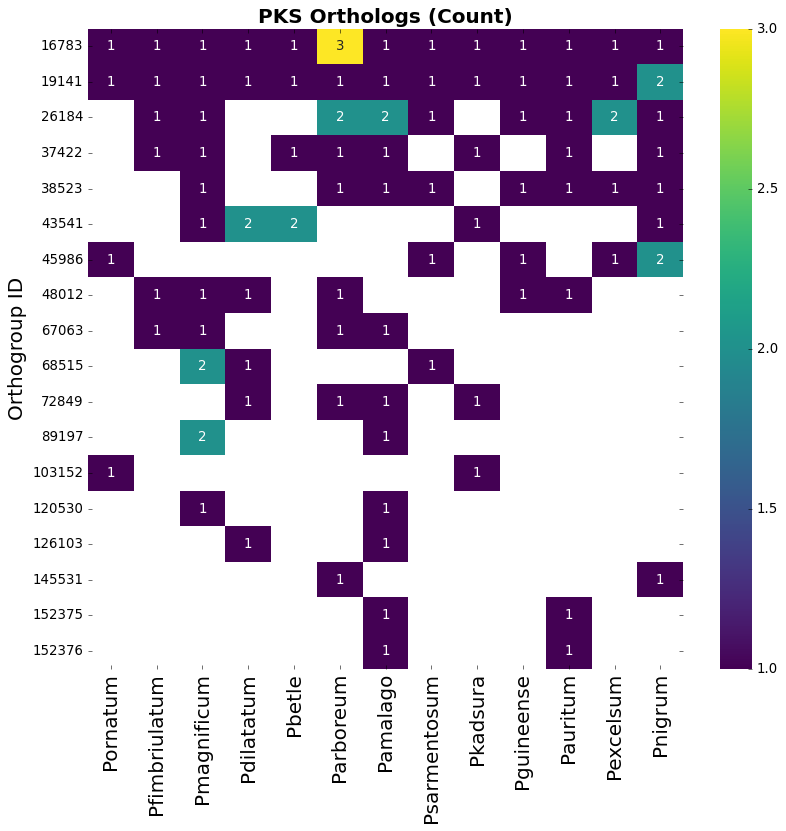

In [9]:
#count orthologs per sample
pks_orths_count= pks_orths.applymap(len).replace(0, np.nan).rename(columns=species_names)   #replace 0 with NaN, use species_names
print(f'Total N° of PKS candidates in orthologs: {pks_orths_count.sum().sum().astype(int)}')

#plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pks_orths_count, annot=True, cmap='viridis')
plt.ylabel('Orthogroup ID', fontdict={'fontsize': 18})
plt.title('PKS Orthologs (Count)', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.tick_params(axis='x', labelsize=18)  # Increase x-axis label size
# axes[0].set_yticklabels(orths_annot.tolist(), fontsize=14) # Increase y-axis label size (orthologs names
plt.show()

Heatmap of orthogroups expression levels. A single expression value is assigned to each entry in an orthogroups table. Either the maximum or the average expression of all orthologs (i.e., each entry in the orthogroup table) across all tissus is taken.

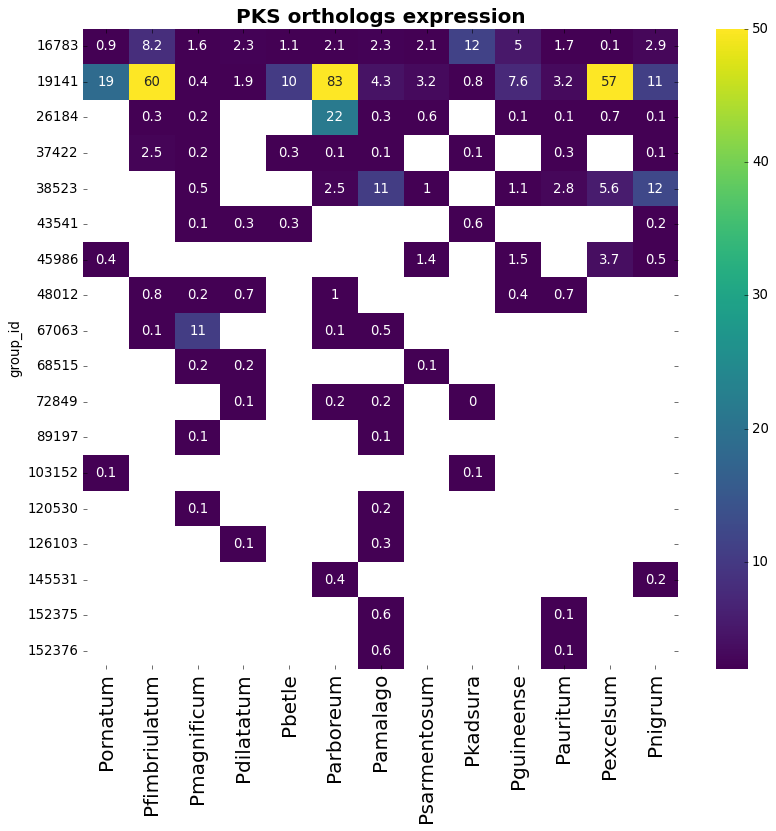

In [20]:
#assign expression values to orthogroups
from src.rnaseq_utils import assign_orth_expr
pks_orths_expr = pks_orths.applymap(lambda x: assign_orth_expr(x,
                                                               proteomes=proteomes_all,
                                                               metric='mean')).rename(columns=species_names) #assign expression values, use species_names

#plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pks_orths_expr, annot=True, cmap='viridis', vmin=2, vmax=50)
plt.title('PKS orthologs expression', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.tick_params(axis='x', labelsize=18)
plt.show()

In [39]:
#assign sequence lenght to orthogroups
from src.rnaseq_utils import assign_len_orth
pks_orths_lenght = pks_orths.applymap(lambda x: assign_len_orth(x,
                                                                proteomes=proteomes_all,
                                                                metric='mean')).rename(columns=species_names) #assign length values, use species_names
pks_orths_lenght = pks_orths_lenght.fillna(0).round(0).astype(int)

# Heatmap with varying cell size - Test

## FROM HERE


In [ ]:
from matplotlib.collections import PatchCollection

N = pks_orths_expr.shape[0]
M = pks_orths_expr.shape[1]
data = data = pks_orths_expr.fillna(0).to_numpy()
c = pks_orths_lenght.to_numpy()

ylabels = pks_orths_expr.index
xlabels = pks_orths_expr.columns

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = data
# c = np.random.rand(N, M)-0.5

fig, ax = plt.subplots()

R = s/s.max()/2
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="RdYlGn")
ax.add_collection(col)


# Here's where we specify the rotation for the x-axis labels
ax.set_xticklabels(xlabels, rotation=90)  # Rotate x ax

ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

fig.colorbar(col)
plt.show()

In [ ]:
### Assign annotation to orthogruops based on blast hits
blast_hits = pd.read_csv('results/blast/pks_hits.csv') #retrieve PKS BLAST results
top_hits = blast_hits.groupby('hit', as_index=False).apply(lambda x: x.sort_values('similarity', ascending=False).head(1)).reset_index(drop=True) #keep only top hit per query per sample

def assign_orth_annotation(orthologs):
    annotation = top_hits[top_hits['hit'].isin(orthologs)]
    return annotation['query'].values

orths_annot = pks_orths[sample_cols].applymap(lambda x: assign_orth_annotation(x))
orths_annot = orths_annot.apply(lambda row: list(set(itertools.chain(*row))), axis=1)

Total N°of PKS in orthogroups W/O Pfam domain: 5


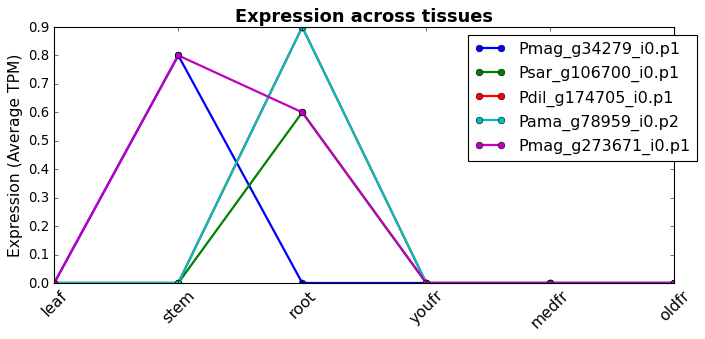

In [13]:
### PKS candidates in orthogroups W/O Pfam domain

#list of all PKS in orthogroups
pks_orths_list = []
for sample in pks_orths[sample_cols].columns: #iterate through each cell in pks_orths
    for genes_list in pks_orths[sample]:
        pks_orths_list.extend(genes_list)

#pks in orthogroups that are NOT in pks.index
pks_wo_pfam = list(set(pks_orths_list) - set(pks.index))
pks_wo_pfam = proteomes_all.loc[pks_wo_pfam]
print(f'Total N°of PKS in orthogroups W/O Pfam domain: {pks_wo_pfam.shape[0]}')

#plot expression values
tpm_cols = [col for col in proteomes_all.columns if 'rep' in col]

def average_tissue_expr(tpm_data, tissue_order=['leaf', 'stem', 'root', 'youfr', 'medfr', 'oldfr']):
    tissue_names = tpm_data.columns.str.split('_').str[0] #extract tissues from column names
    df_avg = tpm_data.groupby(by=tissue_names, axis=1).mean().round(1) #group df by tissue and calculate the mean for each tissue
    df_avg = df_avg[tissue_order] #reorder columns
    df_avg.fillna(0, inplace=True) #replace NaN with 0
    return df_avg

data = average_tissue_expr(pks_wo_pfam[tpm_cols])#.transpose()

# #labels for legend
# labels = [f'{label}_len{proteomes_all.loc[label, "length"]}_cov{proteomes_all.loc[label, "transcript_coverage"].round(1)}' for label in data.index]

def plot_expression(data, size=(10, 4)):
    
    plt.figure(figsize=size)


    # Plot the expression of each gene across tissues
    for index, row in data.iterrows():
        plt.plot(data.columns, row.values, label=index, linewidth=2, marker='o')
    
    #add title
    plt.title('Expression across tissues', fontsize=16, fontweight='bold')
    plt.ylabel('Expression (Average TPM)', fontsize=14)
    plt.xticks(rotation=45, fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best')
    plt.show()

plot_expression(data)

PKS (Pfam) NOT orthologs table: 60


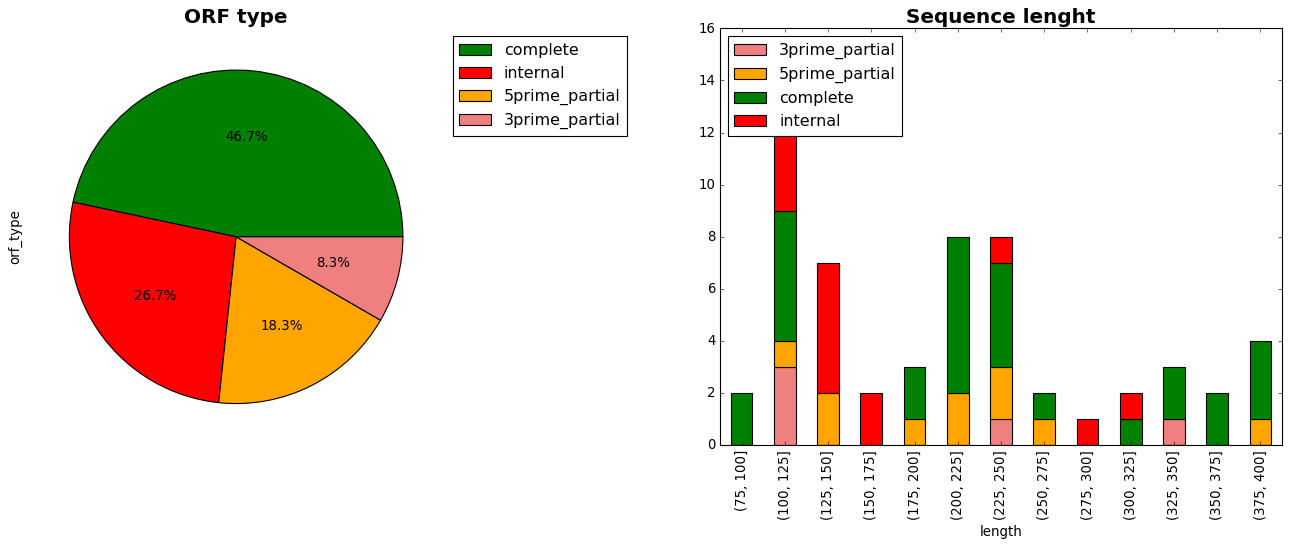

In [15]:
### PKS candidates not in orthogroups
unique_pks = list(set(pks.index) - set(pks_orths_list))
unique_pks = proteomes_all.loc[unique_pks]
unique_pks.shape
print(f'PKS (Pfam) NOT orthologs table: {unique_pks.shape[0]}')


fig, axs = plt.subplots(1, 2, figsize=(17, 7))

#orf_type distribution
pks_orftype = unique_pks['orf_type'].value_counts() #count orf_type

#map colors to orf_type
colormap = {'complete': 'green', '3prime_partial': 'lightcoral', '5prime_partial': 'orange', 'internal': 'red'}
colors = pks_orftype.index.map(lambda x: colormap[x])

#pie chart
pks_orftype.plot(kind='pie', autopct='%1.1f%%', colors=colors, legend=False, labels=None, ax=axs[0])
axs[0].set_title('ORF type', fontdict={'fontsize': 18, 'fontweight': 'bold'})
axs[0].legend(pks_orftype.index, bbox_to_anchor=(1, 1), loc='upper left') #legend

#sequence length distribution
bins = pd.cut(unique_pks['length'], bins=range(0, unique_pks['length'].max(), 25)) #bin pks['length']
count = unique_pks.groupby([bins, 'orf_type']).size().unstack() #count occurrence of orf_types in each bin
count = count[count.sum(axis=1) > 0] #drop all-zeros rows

#stacked bar plot
colors = count.columns.map(lambda x: colormap[x])
count.plot(kind='bar', stacked=True, color=colors, ax=axs[1])
axs[1].set_title('Sequence lenght', fontdict={'fontsize': 18, 'fontweight': 'bold'})
axs[1].legend(title=None, loc='upper left')  # remove legend title

#plot settings
plt.tight_layout()
plt.show()

Total N° of unique PKS: 60


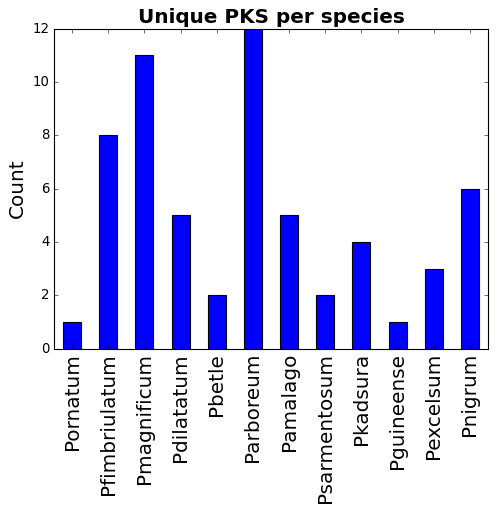

In [16]:
unique_pks_count = unique_pks.groupby('sample').size().rename(index=species_names)#count pks per sample, rename using species_names
print(f'Total N° of unique PKS: {unique_pks_count.sum()}')
plot_count_per_species(unique_pks_count, title = 'Unique PKS per species')

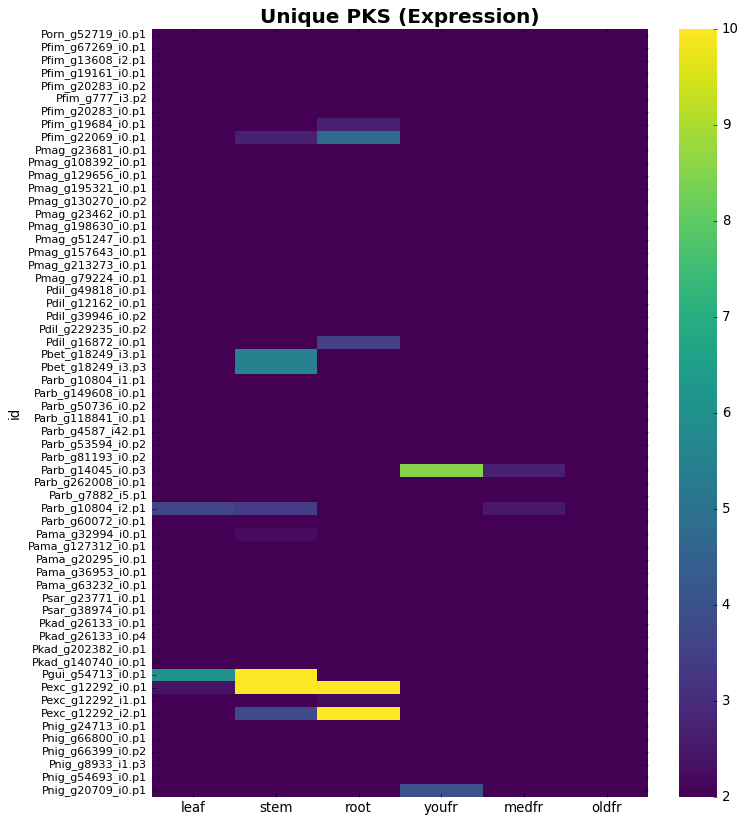

In [245]:
#heatmap of unique_pks_tpm
unique_pks_tpm = unique_pks.sort_values('sample').loc[:, [col for col in proteome.columns if 'rep' in col]] #keep TPM columns
data = average_tissue_expr(unique_pks_tpm)

plt.figure(figsize=(10, 12))
sns.heatmap(data, cmap='viridis', annot=False, yticklabels=True, vmin=2, vmax=10)
plt.yticks(fontsize=10)
plt.title('Unique PKS (Expression)', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.show()

### Phylogenetic tree of PKS candidates
Sequences aligned using MAFFT (locally) and phylogenetic tree builit using iqtree2 (on Aurum)

In [4]:
#write PKS sequences to fasta file
input_file = Path('results/phylogenetic_trees/pks/pks_pfam.fasta')

def write_fasta(df, filename):
    with open(filename, 'w') as f:
        for header, sequence in zip(df.index, df['sequence']):
            f.write(f'>{header}\n{sequence}\n')

write_fasta(pks, input_file)


#multiple sequence alignment (MAFFT)
output_file = input_file.with_name('pks_pfam_msa.fasta')

if not os.path.isfile(output_file):
    !mafft --auto {input_file} > {output_file}
else:
    print(f"File {output_file} already exists.")


#Create iTOL annotation file ###
legend = {prefixes[key]: legend[key] for key in legend if key in prefixes} #rename legend keys with prefixes

#create df with itol annotation
itol_map = {'id': pks.index,
        'range': 'range',
        'color': pks.index.to_series().apply(lambda x:  '#' + next((legend[k] for k in legend if x.startswith(k)), '')),
        'sample': pks['sample'],
        'species': 'species'}

itol_map = pd.DataFrame(itol_map).reset_index(drop=True)

#write file 
filepath = Path('results/phylogenetic_trees/pks/pks_pfam_itol.txt')

with open(filepath, 'w') as f:
    
    #write headers
    f.write('TREE_COLORS\n')
    f.write('SEPARATOR TAB\n')
    f.write('DATA\n')

    #append df with tab-separated format
    itol_map.to_csv(f, sep='\t', index=False, header=False)

File results/phylogenetic_trees/pks/pks_pfam_msa.fasta already exists.
